In [ ]:
# ================== Data Handling ==================
import pandas as pd
import numpy as np

# ================== Visualization ==================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ================== Text Processing ==================
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# ================== Language Detection ==================
from langdetect import detect, DetectorFactory, LangDetectException

# ================== Preprocessing & Utilities ==================
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from dateutil.parser import parse
import warnings
warnings.filterwarnings('ignore')

# ================== Machine Learning ==================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ================== Evaluation Metrics ==================
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn import metrics

# ================== Imbalanced Data ==================
from imblearn.over_sampling import SMOTE

# ================== Explainability ==================
from lime.lime_text import LimeTextExplainer

# ================== Experiment Tracking ==================
import mlflow
import mlflow.sklearn
import mlflow.xgboost

# ================== Pandas Display Settings ==================
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


# 1.0 Data  Loading and Understanding

In [69]:
# load the 1st dataset
data = pd.read_csv('aliexpressdata.csv')
df1 = pd.DataFrame(data)
df1.head()

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
0,6.01E+16,"Same to this one as well, very classy and soft, no bad smells. Perfect for my neck too. Vibrant colors",5.0,2024-11-08,United States
1,6.01E+16,"Beautiful colors, exactly what I wanted, but the item has a defect.",4.0,2024-10-15,United States
2,6.01E+16,"This is top notch scarf, so soft and classy no smells just perfect for my neck. Colors are vibrant too.",5.0,2024-11-08,United States
3,6.01E+16,Item was great; would buy from seller again!,5.0,2024-11-10,United States
4,6.01E+16,Nice item,5.0,2024-10-01,United States


In [70]:
# check data shape and info
print(df1.shape)
print('------------------------------')
df1.info()
print('------------------------------')
# code to count duplicates
duplicates = df1[df1.duplicated()]
print("Number of duplicate rows:", len(duplicates))

print('---------------------------------------------')

# mising data
print(df1.isnull().sum())

(8492, 5)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8492 entries, 0 to 8491
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REVIEW_ID       8492 non-null   object 
 1   REVIEW_CONTENT  7869 non-null   object 
 2   RATING          8128 non-null   float64
 3   DATE            8492 non-null   object 
 4   COUNTRY         8492 non-null   object 
dtypes: float64(1), object(4)
memory usage: 331.8+ KB
------------------------------
Number of duplicate rows: 80
---------------------------------------------
REVIEW_ID           0
REVIEW_CONTENT    623
RATING            364
DATE                0
COUNTRY             0
dtype: int64


In [71]:
# Load the 2nd dataset, preprocess it and merge with the first dataset
# Step 1: Read the data
df2 = pd.read_csv('aliexpressdata2.csv', header=[0,1], skipinitialspace=True)

# Step 2: Fix the double headers
df2.columns = ['Review ID', 'Review Content', 'Rating', 'Date', 'Country']
df2.head()

,Review ID,Review Content,Rating,Date,Country
0,R2PALAAI6TFDFA,"Pros:\r\n* Easy installation.\r\n* Good spray quality from both the overhead and handheld shower heads.\r\n* Affordable price.\r\nCons:\r\n* Flimsy construction.\r\n* Difficult to tighten moving parts.\r\n* Initial leakage at the pipe connection (required additional tape to fix).\r\nOverall: This rain shower head is a good value for those on a budget. The spray is enjoyable, and installation is simple. However, be prepared for potential leakage and a slightly less robust build. If you need a cheap rain shower head, it gets the job done.",3,2025-03-25,United States
1,R3L6U6PSXIYTIR,"The first few times using it the stream is awesome!! It comes out just like a rain shower. After though, the jets get clogged. We have a full house water filtration and purification system and it doesn’t create hard water. So, not sure where the issue lies at.",3,2025-03-21,United States
2,R3MVC57KX3HJ26,"It works great without restrictor but the holder for the smaller head , isnt very good , it slips off slamming onto the tub , it is annoying but the main head I'm happy with and installed so I'm ot returning but being more cautious about that next buy",3,2025-04-08,United States
3,R3UYPWQEV6JHRS,"Got here quick, easy and convenient to install. The WAND is high pressure, the main shower head is a low pressure rain style. Not what I wanted, misleading title and description. It works, doesn't leak, so you get 3/5 stars.",3,2025-03-26,United States
4,R3DUI9YX2553QI,Es una buena regadera al principio pero al poco tiempo deja de salir el agua de la shower head grande. Cosa que nunca me había pasado con ninguna regadera.,3,2025-04-01,United States


In [72]:
# check data shape and info
print(df2.shape)
print('------------------------------')
df2.info()
print('------------------------------')
# code to count duplicates
duplicates = df2[df2.duplicated()]
print("Number of duplicate rows:", len(duplicates))

print('---------------------------------------------')

# mising data
print(df2.isnull().sum())

(4329, 5)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4329 entries, 0 to 4328
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review ID       4327 non-null   object
 1   Review Content  4208 non-null   object
 2   Rating          4329 non-null   int64 
 3   Date            4315 non-null   object
 4   Country         4329 non-null   object
dtypes: int64(1), object(4)
memory usage: 169.2+ KB
------------------------------
Number of duplicate rows: 108
---------------------------------------------
Review ID           2
Review Content    121
Rating              0
Date               14
Country             0
dtype: int64


In [73]:
# Step 3: Clean messy characters safely
def fix_text(text):
    if pd.isnull(text):
        return text
    text = str(text)
    text = (text
            .replace('â', "'")
            .replace('â', '-')
            .replace('â', '"')
            .replace('â', '"')
            .replace('â¢', '•')
            .replace('â¦', '...')
            .replace('â“', '-')
           )
    return text

df2['Review Content'] = df2['Review Content'].apply(fix_text)

# Step 4: Define helper function to check if a string is a valid date
def is_valid_date(s):
    try:
        parse(str(s), fuzzy=False)
        return True
    except:
        return False

# Step 5: Merge misplaced comments into 'Review Content'
def merge_misplaced_comments(row):
    if pd.isnull(row['Review Content']) or str(row['Review Content']).strip() == '':
        parts = []
        # Check if Review ID is not starting with "R" and not empty
        if pd.notnull(row['Review ID']) and not str(row['Review ID']).startswith('R'):
            parts.append(str(row['Review ID']).strip())
        # Check if Date is not a real date and not empty
        if pd.notnull(row['Date']) and not is_valid_date(row['Date']):
            parts.append(str(row['Date']).strip())
        # Merge parts if any
        if parts:
            return ' '.join(parts)
    return row['Review Content']

df2['Review Content'] = df2.apply(merge_misplaced_comments, axis=1)

# Step 6: Drop rows where 'Review Content' or 'Rating' are still missing
df2 = df2.dropna(subset=['Review Content', 'Rating'])

# Step 7: Reset index
df2 = df2.reset_index(drop=True)

# check the data
df2[['Review Content', 'Rating']].head()


,Review Content,Rating
0,"Pros:\r\n* Easy installation.\r\n* Good spray quality from both the overhead and handheld shower heads.\r\n* Affordable price.\r\nCons:\r\n* Flimsy construction.\r\n* Difficult to tighten moving parts.\r\n* Initial leakage at the pipe connection (required additional tape to fix).\r\nOverall: This rain shower head is a good value for those on a budget. The spray is enjoyable, and installation is simple. However, be prepared for potential leakage and a slightly less robust build. If you need a cheap rain shower head, it gets the job done.",3
1,"The first few times using it the stream is awesome!! It comes out just like a rain shower. After though, the jets get clogged. We have a full house water filtration and purification system and it doesn’t create hard water. So, not sure where the issue lies at.",3
2,"It works great without restrictor but the holder for the smaller head , isnt very good , it slips off slamming onto the tub , it is annoying but the main head I'm happy with and installed so I'm ot returning but being more cautious about that next buy",3
3,"Got here quick, easy and convenient to install. The WAND is high pressure, the main shower head is a low pressure rain style. Not what I wanted, misleading title and description. It works, doesn't leak, so you get 3/5 stars.",3
4,Es una buena regadera al principio pero al poco tiempo deja de salir el agua de la shower head grande. Cosa que nunca me había pasado con ninguna regadera.,3


In [ ]:
# Merge the file
# Step 1: Load the two data files

# Step 2: Standardize the column names (make both consistent)
df1.columns = ['Review ID', 'Review Content', 'Rating', 'Date', 'Country']
df2.columns = ['Review ID', 'Review Content', 'Rating', 'Date', 'Country']

# Step 3: Concatenate both DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Step 4 : Drop exact duplicates if any
combined_df = combined_df.drop_duplicates()

# Step 5 : Reset index
combined_df = combined_df.reset_index(drop=True)

# Final DataFrame is ready!
combined_df.head()

# Save
combined_df.to_csv('aliexpressdata_cleaned.csv', index=False)


In [75]:
# check data shape and info
print(combined_df.shape)
print('-----------------------------')
combined_df.info()

print('-----------------------------')
# check index and columns
print(combined_df.shape)
print('------------------')
print(combined_df.columns)

combined_df.info()

# code to count duplicates
duplicates = combined_df[combined_df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

print('---------------------------------------------')

# mising data
combined_df.isnull().sum()

# check the data statistics
combined_df.describe(include='all').round(2)

(12620, 5)
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12620 entries, 0 to 12619
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review ID       12619 non-null  object 
 1   Review Content  12042 non-null  object 
 2   Rating          12279 non-null  float64
 3   Date            12609 non-null  object 
 4   Country         12620 non-null  object 
dtypes: float64(1), object(4)
memory usage: 493.1+ KB
-----------------------------
(12620, 5)
------------------
Index(['Review ID', 'Review Content', 'Rating', 'Date', 'Country'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12620 entries, 0 to 12619
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review ID       12619 non-null  object 
 1   Review Content  12042 non-null  object 
 2   Rating          12279 non-null  float64
 3   

,Review ID,Review Content,Rating,Date,Country
count,12619,12042,12279.00,12609,12620
unique,10490,11718,NaN,1647,109
top,6.01E+16,Good,NaN,2025-03-24,United Kingdom
freq,574,38,NaN,144,4379
mean,NaN,NaN,3.55,NaN,NaN
std,NaN,NaN,1.50,NaN,NaN
min,NaN,NaN,1.00,NaN,NaN
25%,NaN,NaN,2.00,NaN,NaN
50%,NaN,NaN,4.00,NaN,NaN
75%,NaN,NaN,5.00,NaN,NaN


# Review Sample Check for: 1*, 3*** and 5***** reviews

In [76]:
# Print one example where RATING == 1
example_review = combined_df[combined_df['Rating'] == 1]['Review Content'].iloc[0]
example_review

'I received my package; however, I had to reach out to the seller beforehand regarding their choice of delivery courier, Better Trucks. This company is known for its low ratings and frequent delivery issues. When I raised my concerns with the seller, they completely dismissed them and simply told me to contact my local post office—which makes no sense, as Better Trucks is not a postal service.\n\nAlthough my package did eventually arrive, it was very late in the evening. Due to the seller’s poor customer service and lack of concern for consumer feedback, I will not be ordering from them again. AliExpress used to rely on DHL, a reputable courier, and I’m unsure why that has changed.'

In [77]:
# Print one example where RATING == 3
example_review = combined_df[combined_df['Rating'] == 3]['Review Content'].iloc[0]
example_review


'I order a 22 and it looks like a 16 inch but other than that it’s very soft. You should but it but if u want a long one grab a 30.'

In [78]:
# Print one example where RATING == 5
example_review = combined_df[combined_df['Rating'] == 5]['Review Content'].iloc[0]
example_review


'Same to this one as well, very classy and soft, no bad smells. Perfect for my neck too. Vibrant colors '

# 2.0 Quick Exploratory Data Analysis

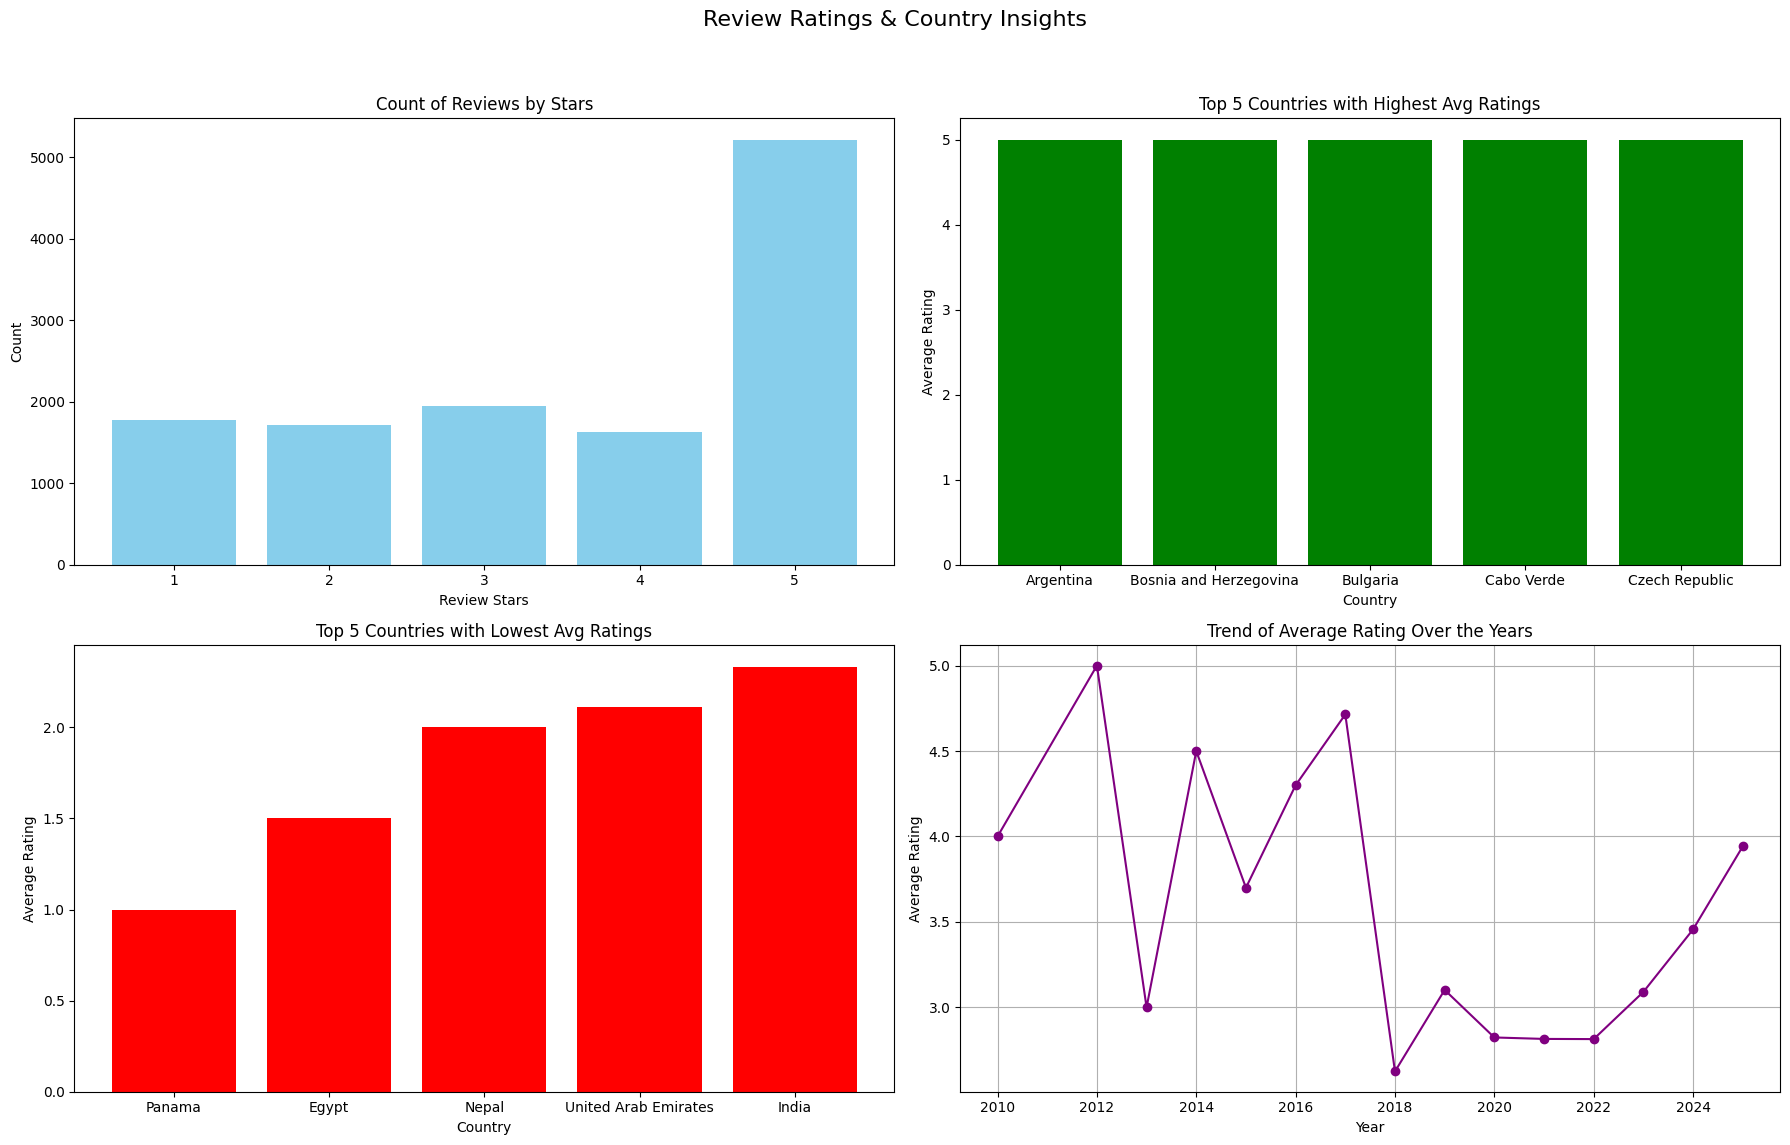

In [79]:
import matplotlib.pyplot as plt

# Prepare figure with 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Review Ratings & Country Insights', fontsize=16)

# --- 1. Count of Reviews by Stars ---
rating_counts = combined_df['Rating'].value_counts().sort_index()
axs[0, 0].bar(rating_counts.index, rating_counts.values, color='skyblue')
axs[0, 0].set_title('Count of Reviews by Stars')
axs[0, 0].set_xlabel('Review Stars')
axs[0, 0].set_ylabel('Count')

# --- 2. Top 5 Countries with Highest Ratings ---
top_5_highest = combined_df.groupby('Country')['Rating'].mean().nlargest(5)
axs[0, 1].bar(top_5_highest.index, top_5_highest.values, color='green')
axs[0, 1].set_title('Top 5 Countries with Highest Avg Ratings')
axs[0, 1].set_xlabel('Country')
axs[0, 1].set_ylabel('Average Rating')

# --- 3. Top 5 Countries with Lowest Ratings ---
top_5_lowest = combined_df.groupby('Country')['Rating'].mean().nsmallest(5)
axs[1, 0].bar(top_5_lowest.index, top_5_lowest.values, color='red')
axs[1, 0].set_title('Top 5 Countries with Lowest Avg Ratings')
axs[1, 0].set_xlabel('Country')
axs[1, 0].set_ylabel('Average Rating')

# --- 4. Trend of Average Rating Over the Years ---
if 'Date' in combined_df.columns:
    combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')
    combined_df['Year'] = combined_df['Date'].dt.year

if 'Year' in combined_df.columns:
    yearly_ratings = combined_df.groupby('Year')['Rating'].mean()
    axs[1, 1].plot(yearly_ratings.index, yearly_ratings.values, marker='o', linestyle='-', color='purple')
    axs[1, 1].set_title('Trend of Average Rating Over the Years')
    axs[1, 1].set_xlabel('Year')
    axs[1, 1].set_ylabel('Average Rating')
    axs[1, 1].grid(True)
else:
    axs[1, 1].text(0.5, 0.5, "No 'DATE' or 'YEAR' column available", ha='center', va='center', fontsize=12)
    axs[1, 1].set_axis_off()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


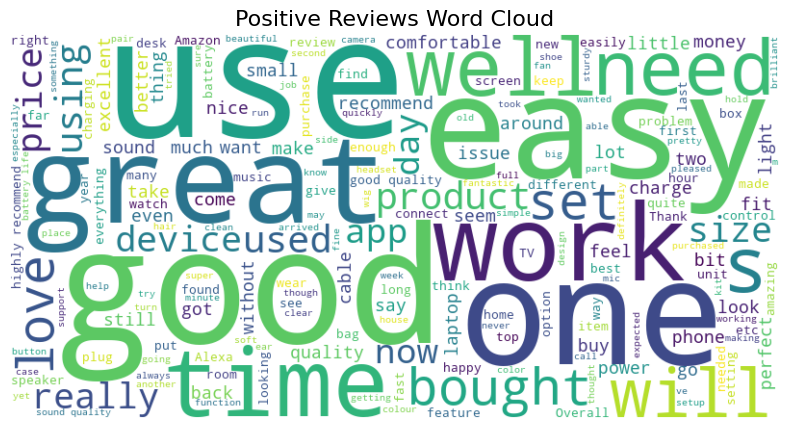

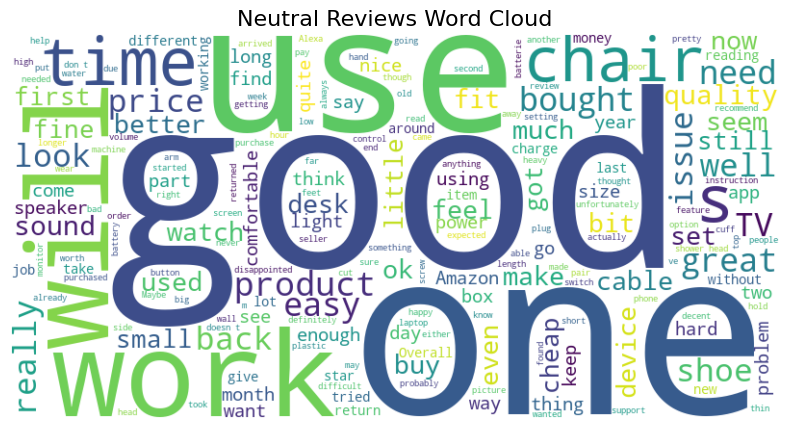

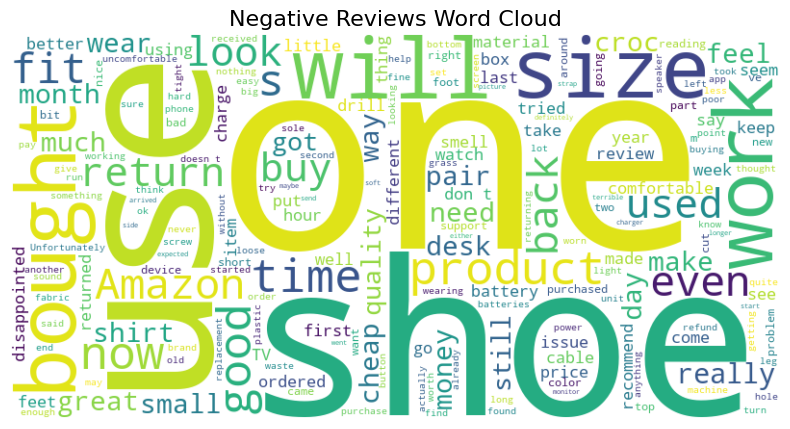

In [ ]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Positive Reviews (RATING >= 4)
positive_reviews = combined_df[combined_df['Rating'] >= 4]['Review Content'].dropna().str.cat(sep=' ')
generate_wordcloud(positive_reviews, "Positive Reviews Word Cloud")

# Neutral Reviews (RATING == 3)
neutral_reviews = combined_df[combined_df['Rating'] == 3]['Review Content'].dropna().str.cat(sep=' ')
generate_wordcloud(neutral_reviews, "Neutral Reviews Word Cloud")

# Negative Reviews (RATING <= 2)
negative_reviews = combined_df[combined_df['Rating'] <= 2]['Review Content'].dropna().str.cat(sep=' ')
generate_wordcloud(negative_reviews, "Negative Reviews Word Cloud")

#  3.0 Data Preprocessing - Cleaning and Negation Handling

In [81]:
# Ensure consistent language detection
DetectorFactory.seed = 0

# Initialize text preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
stop_words.update({"would", "shall", "could", "might"})  # Add more generic stopwords
stop_words.discard("not")  # Keep "not" to capture negation sentiment

# Detect English text
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Negation handler: prefixes words after negation (e.g., not good → NOT_good)
def handle_negation(text):
    tokens = word_tokenize(text.lower())
    result = []
    negate = False
    for word in tokens:
        if word in {"not", "no", "never", "n't"}:
            negate = True
            result.append(word)
        elif negate:
            result.append("NOT_" + word)
            negate = False
        else:
            result.append(word)
    return result

# Full text cleaning pipeline
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")              # Remove emojis
    text = re.sub(r"http\S+", "", text)                       # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)                   # Remove non-alphabetic characters
    tokens = handle_negation(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)


#  3.1 Apply Preprocessing to DataFrame

In [82]:
# Drop duplicates and null reviews
df_cleaned = combined_df[['Review Content', 'Rating']].drop_duplicates().dropna(subset=['Review Content'])

# Keep only English reviews
df_cleaned = df_cleaned[df_cleaned['Review Content'].apply(lambda x: is_english(str(x)))]

# Clean the review text
df_cleaned['cleaned_review'] = df_cleaned['Review Content'].apply(lambda x: clean_text(str(x)))

# Label sentiment
df_cleaned["sentiment"] = df_cleaned["Rating"].apply(lambda x: "Positive" if x >= 4 else "Neutral" if x == 3 else "Negative")
df_cleaned.drop(columns=['Review Content', 'Rating'], inplace=True)
df_cleaned.head()

,cleaned_review,sentiment
0,one well classy soft NOT_bad smell perfect neck vibrant color,Positive
1,beautiful color exactly wanted item defect,Positive
2,top notch scarf soft classy NOT_smells perfect neck color vibrant,Positive
3,item great buy seller,Positive
4,nice item,Positive


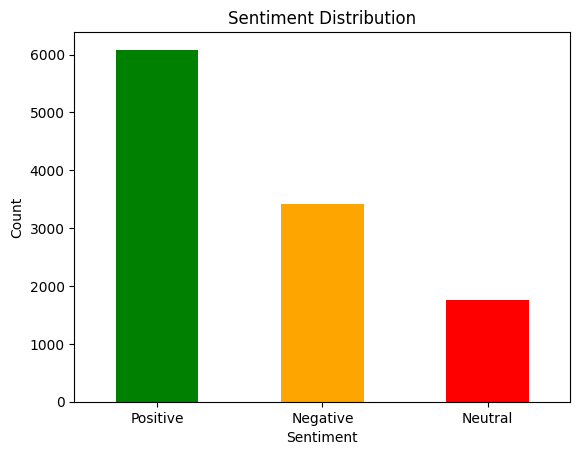

sentiment
Positive    6085
Negative    3411
Neutral     1757
Name: count, dtype: int64


In [83]:
# check sentiment distribution
df_cleaned['sentiment'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

print(df_cleaned['sentiment'].value_counts())

# 4. Feature Engineering & Data Splitting

In [84]:
#df_cleaned_copy = df_cleaned.copy()

# Vectorize text using TF-IDF with unigrams, bigrams, trigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df_cleaned["cleaned_review"])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned["sentiment"])

# Feature selection using chi-squared
chi2_scores, _ = chi2(X, y)
top_features = np.argsort(chi2_scores)[-5000:]  # Top 5,000 features
X_selected = X[:, top_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


# 5.0 Modelling: Selection, Training  and Evaluation 
 
Sentiment Analysis Models:

We'll evaluate Rule-Based and Machine Learning models

Rule-Based Approach (Lexicon-Based) using:

     * Using VADER from nltk
     * TextBlob
     *  SentiWordNet 

In [85]:
df_cleaned_copy = df_cleaned.copy()

# Vectorize text using TF-IDF with unigrams, bigrams, trigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df_cleaned_copy["cleaned_review"])

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned_copy["sentiment"])

#Feature selection using chi-squared
chi2_scores, _ = chi2(X, y)
top_features = np.argsort(chi2_scores)[-5000:]  # Top 5,000 features
X_selected = X[:, top_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


# 5.1  Rule-Based Sentiment Analysis (Baseline)


In [86]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn  # Import SentiWordNet

# VADER Sentiment Analysis
def vader_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# TextBlob Sentiment Analysis
def textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# SentiWordNet Sentiment Analysis
def sentiwordnet_sentiment(text):
    words = text.split()
    pos_score, neg_score = 0, 0
    for word in words:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            pos_score += synsets[0].pos_score()
            neg_score += synsets[0].neg_score()
    if pos_score > neg_score:
        return 'Positive'
    elif neg_score > pos_score:
        return 'Negative'
    else:
        return 'Neutral'

# Evaluate Rule-Based Models
def evaluate_model(preds, y_true, model_name, label_encoder):
    print(f"\n{model_name} Sentiment Analysis")
    print("Accuracy:", accuracy_score(y_true, preds))
    print(classification_report(y_true, preds, target_names=label_encoder.classes_))

# Predictions and Evaluation
vader_preds = [vader_sentiment(text) for text in df_cleaned_copy['cleaned_review']]
evaluate_model(vader_preds, df_cleaned_copy['sentiment'], 'VADER', label_encoder)

textblob_preds = [textblob_sentiment(text) for text in df_cleaned_copy['cleaned_review']]
evaluate_model(textblob_preds, df_cleaned_copy['sentiment'], 'TextBlob', label_encoder)

swn_preds = [sentiwordnet_sentiment(text) for text in df_cleaned_copy['cleaned_review']]
evaluate_model(swn_preds, df_cleaned_copy['sentiment'], 'SentiWordNet', label_encoder)



VADER Sentiment Analysis
Accuracy: 0.6306762641073491
              precision    recall  f1-score   support

    Negative       0.65      0.41      0.50      3411
     Neutral       0.20      0.11      0.15      1757
    Positive       0.68      0.90      0.78      6085

    accuracy                           0.63     11253
   macro avg       0.51      0.48      0.47     11253
weighted avg       0.60      0.63      0.59     11253


TextBlob Sentiment Analysis
Accuracy: 0.6086376966142362
              precision    recall  f1-score   support

    Negative       0.65      0.36      0.46      3411
     Neutral       0.17      0.08      0.11      1757
    Positive       0.64      0.90      0.75      6085

    accuracy                           0.61     11253
   macro avg       0.49      0.45      0.44     11253
weighted avg       0.57      0.61      0.56     11253


SentiWordNet Sentiment Analysis
Accuracy: 0.5727361592464232
              precision    recall  f1-score   support

    Nega

#  5.2 ML Models, Hyperparameters Tunning, MLflow Tracking & Evaluation


In [87]:
# Minimal Parameter Grids
models_with_params = {
    "LogisticRegression": (
        LogisticRegression(class_weight="balanced", max_iter=2000),
        {
            "C": [0.5, 1.0, 5.0, 10.0],
            "solver": ["liblinear"]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {
            "n_estimators": [50, 100],
            "max_depth": [None, 10]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.1, 0.3]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.5, 1.0]
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(),
        {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    ),
    "SVM": (
        SVC(probability=True),
        {
            "C": [0.5, 1.0],
            "kernel": ["linear", "rbf"]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
        {
            "n_estimators": [50, 100],
            "max_depth": [3, 6],
            "learning_rate": [0.1, 0.3]
        }
    )
}


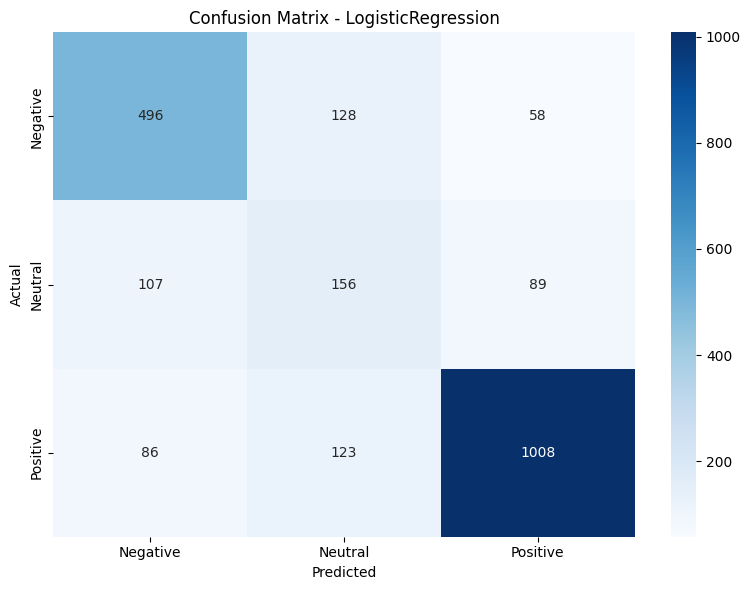

✅ Confusion matrix for LogisticRegression displayed.


2025/05/14 10:57:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression trained, tuned, and tracked.
🏃 View run LogisticRegression at: http://127.0.0.1:5000/#/experiments/1/runs/81511679960241af841405b3800a0e61
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       682
           1       0.38      0.44      0.41       352
           2       0.87      0.83      0.85      1217

    accuracy                           0.74      2251
   macro avg       0.66      0.67      0.66      2251
weighted avg       0.75      0.74      0.74      2251

📈 AUC Score: 0.8325141358725411


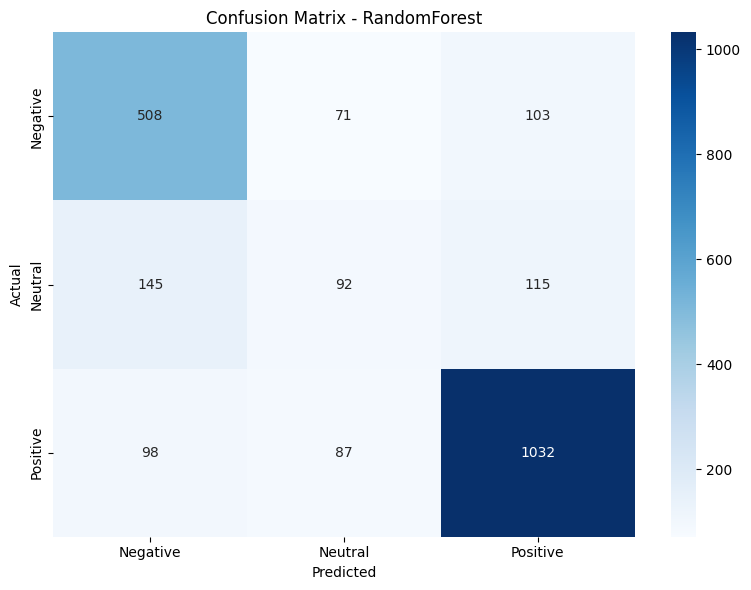

✅ Confusion matrix for RandomForest displayed.


2025/05/14 10:57:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ RandomForest trained, tuned, and tracked.
🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/1/runs/affc428448ca4991b076729bd93c9855
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       682
           1       0.37      0.26      0.31       352
           2       0.83      0.85      0.84      1217

    accuracy                           0.73      2251
   macro avg       0.62      0.62      0.62      2251
weighted avg       0.71      0.73      0.71      2251

📈 AUC Score: 0.8112784242197151


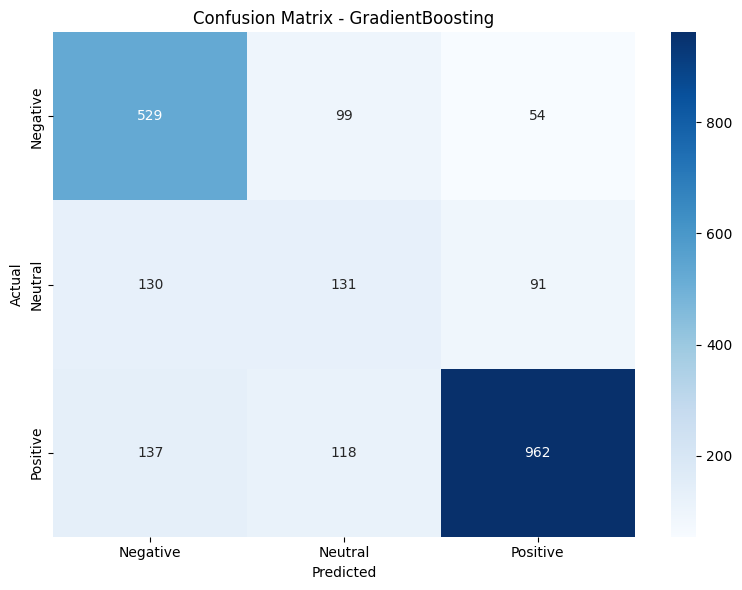

✅ Confusion matrix for GradientBoosting displayed.


2025/05/14 10:58:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ GradientBoosting trained, tuned, and tracked.
🏃 View run GradientBoosting at: http://127.0.0.1:5000/#/experiments/1/runs/b0e42c9c283a421b8c5921acba261371
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       682
           1       0.38      0.37      0.37       352
           2       0.87      0.79      0.83      1217

    accuracy                           0.72      2251
   macro avg       0.64      0.65      0.64      2251
weighted avg       0.73      0.72      0.72      2251

📈 AUC Score: 0.8245093294668578


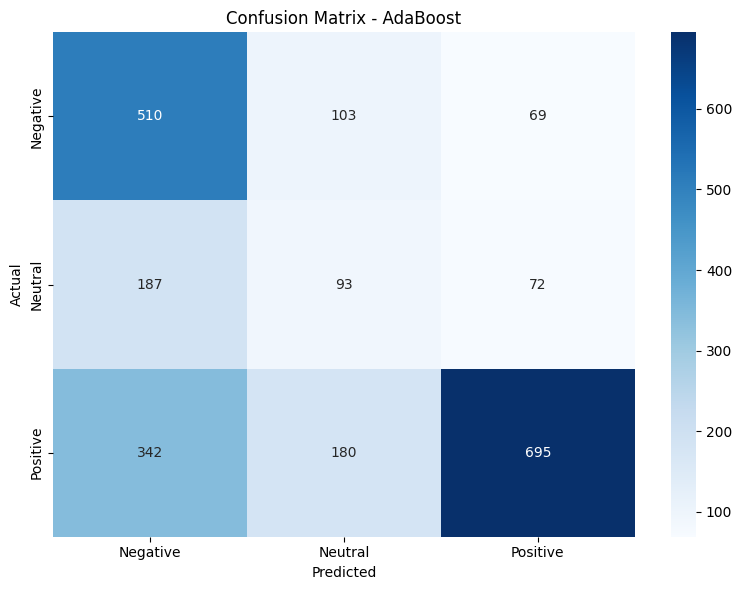

✅ Confusion matrix for AdaBoost displayed.


2025/05/14 10:59:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ AdaBoost trained, tuned, and tracked.
🏃 View run AdaBoost at: http://127.0.0.1:5000/#/experiments/1/runs/51305c9802cd4c16b158d42a4911f26e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.75      0.59       682
           1       0.25      0.26      0.26       352
           2       0.83      0.57      0.68      1217

    accuracy                           0.58      2251
   macro avg       0.52      0.53      0.51      2251
weighted avg       0.64      0.58      0.59      2251

📈 AUC Score: 0.7238829545710116


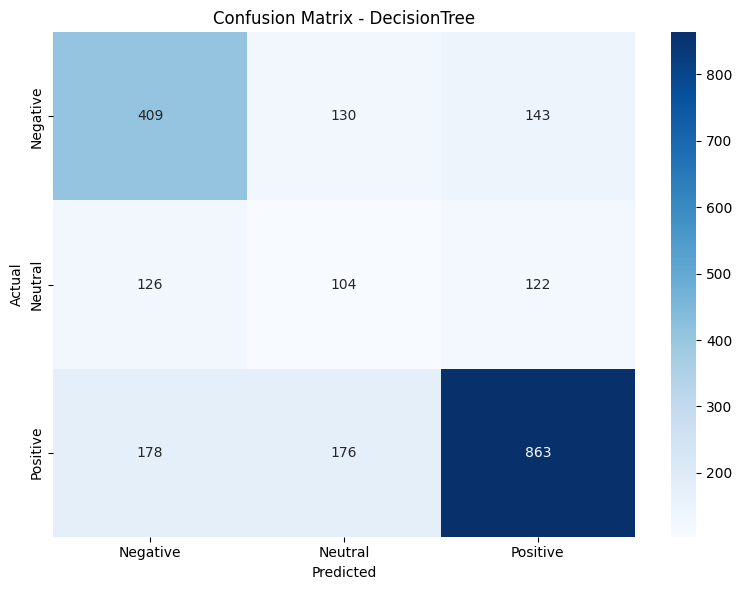

✅ Confusion matrix for DecisionTree displayed.


2025/05/14 10:59:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ DecisionTree trained, tuned, and tracked.
🏃 View run DecisionTree at: http://127.0.0.1:5000/#/experiments/1/runs/de62f50c58b8454f8eb2d08d95a1ae64
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       682
           1       0.25      0.30      0.27       352
           2       0.77      0.71      0.74      1217

    accuracy                           0.61      2251
   macro avg       0.53      0.53      0.53      2251
weighted avg       0.63      0.61      0.62      2251

📈 AUC Score: 0.6508253715196627


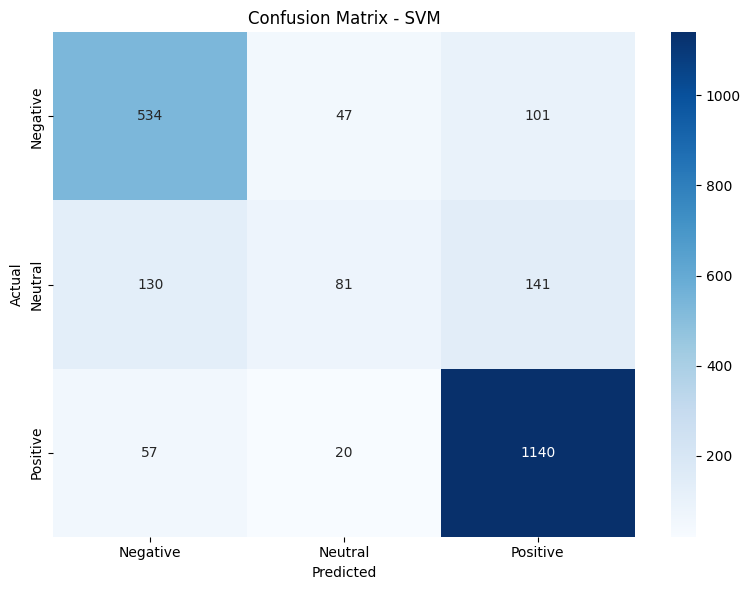

✅ Confusion matrix for SVM displayed.


2025/05/14 11:04:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ SVM trained, tuned, and tracked.
🏃 View run SVM at: http://127.0.0.1:5000/#/experiments/1/runs/3b38f41e03fb4ef1868f5389eafa831a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       682
           1       0.55      0.23      0.32       352
           2       0.82      0.94      0.88      1217

    accuracy                           0.78      2251
   macro avg       0.70      0.65      0.65      2251
weighted avg       0.76      0.78      0.76      2251

📈 AUC Score: 0.8563587496452146


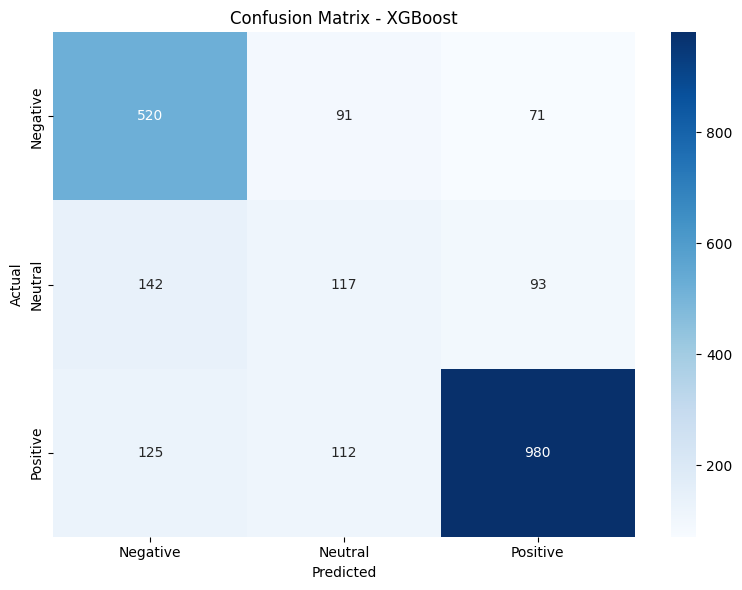

✅ Confusion matrix for XGBoost displayed.


2025/05/14 11:06:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ XGBoost trained, tuned, and tracked.
🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/1/runs/d4b8c9dde1cf4d809a27f625a8c1f4f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       682
           1       0.37      0.33      0.35       352
           2       0.86      0.81      0.83      1217

    accuracy                           0.72      2251
   macro avg       0.63      0.63      0.63      2251
weighted avg       0.72      0.72      0.72      2251

📈 AUC Score: 0.8225207722841517
Available models in best_models dictionary: dict_keys(['LogisticRegression', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'DecisionTree', 'SVM', 'XGBoost'])
Using 'LogisticRegression' for LIME interpretation.
Selected Review: ive tried different brand opinion excellent become favorite extremely dry take lot moisture keep feeling dry comfortable brand ive use 

In [ ]:

# 💾 Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Sentiment Analysis")

# ✅ Plotting Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    print(f"✅ Confusion matrix for {model_name} displayed.")

# 🧠 Train and Track Model with MLflow
def train_and_track_model(name, model, param_grid, X_train, y_train, X_test, y_test, label_encoder):
    with mlflow.start_run(run_name=name):
        # 🌀 Handle class imbalance with SMOTE
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        # 🔍 Grid Search for Hyperparameter Tuning
        grid = GridSearchCV(model, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
        grid.fit(X_train_res, y_train_res)
        best_model = grid.best_estimator_

        # 🔮 Predictions
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)

        # 🎯 Log Parameters and Metrics
        mlflow.log_param("model", name)
        mlflow.log_params(grid.best_params_)
        mlflow.log_metrics({
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred, average="macro"),
            "precision": precision_score(y_test, y_pred, average="macro"),
            "recall": recall_score(y_test, y_pred, average="macro"),
            "roc_auc": roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
        })

        # 🗺️ Plot Confusion Matrix
        plot_confusion_matrix(y_test, y_pred, name, label_encoder)

        # ✅ Log Model
        if name.lower() == "xgboost":
            mlflow.xgboost.log_model(best_model, "model")
        else:
            mlflow.sklearn.log_model(best_model, "model")
        
        print(f"✅ {name} trained, tuned, and tracked.")
        return best_model

# 📝 Classification Report and AUC
def evaluate_model(y_test, y_pred, y_prob):
    print("🔍 Classification Report:")
    print(classification_report(y_test, y_pred))
    print("📈 AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# 🌟 LIME Interpretation
def interpret_with_lime(best_model, label_encoder, vectorizer, df_cleaned, y_test):
    pipeline = make_pipeline(vectorizer, best_model)
    explainer = LimeTextExplainer(class_names=label_encoder.classes_)

    # 💡 Select Random Sample
    idx = np.random.randint(0, len(y_test))
    sample_text = df_cleaned.iloc[idx]["cleaned_review"]

    print(f"Selected Review: {sample_text}")
    #print(f"True Sentiment: {label_encoder.inverse_transform([y_test.iloc[idx]])[0]}")
    print(f"True Sentiment: {label_encoder.inverse_transform([y_test[idx]])[0]}")


    # 🌐 LIME Explanation
    exp = explainer.explain_instance(sample_text, pipeline.predict_proba, num_features=10, top_labels=1)
    exp.save_to_file("lime_explanation.html")
    print("✅ LIME explanation saved as 'lime_explanation.html'.")

# 🔁 Loop Over Models
best_models = {}
for name, (model, param_grid) in models_with_params.items():
    best_model = train_and_track_model(name, model, param_grid, X_train, y_train, X_test, y_test, label_encoder)
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)

    # 📝 Evaluation
    evaluate_model(y_test, y_pred, y_prob)
    best_models[name] = best_model

# 🔍 Debug: Print available models
print("Available models in best_models dictionary:", best_models.keys())


# 🌟 Model Interpretation with LIME
chosen_model_name = "Logistic Regression" if "Logistic Regression" in best_models else list(best_models.keys())[0]
print(f"Using '{chosen_model_name}' for LIME interpretation.")
interpret_with_lime(best_models[chosen_model_name], label_encoder, vectorizer, df_cleaned, y_test)



# 6.0 Model Intrepretation

In [89]:
# 🌟 Interpret the Best Model with LIME
def interpret_with_lime(best_model, label_encoder, vectorizer, df_cleaned, y_test):
    # 💡 Prepare the pipeline
    pipeline = make_pipeline(vectorizer, best_model)
    explainer = lime.lime_text.LimeTextExplainer(class_names=label_encoder.classes_)

    # 💡 Choose a random sample for explanation
    idx = np.random.randint(0, len(y_test))
    sample_text = df_cleaned.iloc[idx]["cleaned_review"]

    print(f"Selected Review: {sample_text}")
    print(f"True Sentiment: {label_encoder.inverse_transform([y_test[idx]])[0]}")
    

    # 🌐 Generate LIME Explanation
    exp = explainer.explain_instance(sample_text, pipeline.predict_proba, num_features=10, top_labels=1)
    exp.save_to_file("lime_explanation.html")
    print("✅ LIME explanation saved. Open 'lime_explanation.html' to view.")
